In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym
import matplotlib.pyplot as plt

pendulum = gym.make("Pendulum-v1")
# acrobot = gym.make('Acrobot-v1', render_mode="rgb_array")
car = gym.make("MountainCarContinuous-v0", render_mode="rgb_array", goal_velocity=0.1) 

In [14]:
def plot_evaluated_return(all_ep_returns):
    avg_ret = []
    steps = []
    all_returns = []
    mod = len(avg_ret)%10
    all_ep_returns = all_ep_returns[:len(all_ep_returns)-mod]
    for a in all_ep_returns:
        all_returns.append(a[1])
    
    for r in range(len(all_ep_returns)):
        avg_ret.append(np.mean(all_returns[r:r+10]))
        steps.append(all_ep_returns[r][0])

    plt.plot(steps, avg_ret)
    plt.show

In [15]:
def save_ep_returns(ep_all_returns, filename):
    """Save list of 2D coordinates to a .npy file."""
    arr = np.array(ep_all_returns, dtype=np.float32)
    np.save(filename, arr)
    print(f"Saved ep_all_returns to {filename} with shape {arr.shape}")

def load_ep_returns(filename):
    """Load the saved list of 2D coordinates."""
    arr = np.load(filename)
    ep_all_returns = arr.tolist()
    print(f"Loaded ep_all_returns from {filename} with shape {arr.shape}")
    return ep_all_returns

SAC

In [ ]:
# ============================================================
# Replay Buffer
# ============================================================
class ReplayBuffer:
    def __init__(self, obs_dim, act_dim, size):
        self.obs_buf      = np.zeros((size, obs_dim), dtype=np.float32)
        self.next_obs_buf = np.zeros((size, obs_dim), dtype=np.float32)
        self.acts_buf     = np.zeros((size, act_dim), dtype=np.float32)
        self.rews_buf     = np.zeros(size, dtype=np.float32)
        self.done_buf     = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, size

    def store(self, obs, act, rew, next_obs, done):
        self.obs_buf[self.ptr]      = obs
        self.acts_buf[self.ptr]     = act
        self.rews_buf[self.ptr]     = rew
        self.next_obs_buf[self.ptr] = next_obs
        self.done_buf[self.ptr]     = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self, batch_size):
        idxs = np.random.randint(0, self.size, size=batch_size)
        batch = dict(
            obs      = self.obs_buf[idxs],
            acts     = self.acts_buf[idxs],
            rews     = self.rews_buf[idxs],
            next_obs = self.next_obs_buf[idxs],
            done     = self.done_buf[idxs],
        )
        return batch


# ============================================================
# Neural Network: simple MLP builder
# ============================================================
def mlp(sizes, activation=nn.ReLU, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)


# ============================================================
# Gaussian Policy (Actor)
# ============================================================
class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes, action_limit):
        super().__init__()
        self.net = mlp([obs_dim] + hidden_sizes,
                       activation=nn.ReLU,
                       output_activation=nn.ReLU)
        
        self.mean_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.log_std_layer = nn.Linear(hidden_sizes[-1], act_dim)

        self.action_limit = action_limit
        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX =  2

    def forward(self, obs):
        x = self.net(obs)
        mean = self.mean_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        return mean, log_std.exp()

    def sample(self, obs):
        mean, std = self.forward(obs)
        normal = Normal(mean, std)

        z = normal.rsample()               # reparameterization
        a = torch.tanh(z)
        action = self.action_limit * a

        # log π(a|s)
        log_prob = normal.log_prob(z) - torch.log(1 - a.pow(2) + 1e-7)
        log_prob = log_prob.sum(axis=-1, keepdim=True)

        mean_action = self.action_limit * torch.tanh(mean)
        return action, log_prob, mean_action


# ============================================================
# Q-value Networks (Critics)
# ============================================================
class QNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + hidden_sizes + [1],
                     activation=nn.ReLU,
                     output_activation=nn.Identity)

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.q(x)


# ============================================================
# Soft Actor-Critic Agent
# ============================================================
class SACAgent:
    def __init__(self, obs_dim, act_dim, action_limit,
                 gamma=0.99, tau=0.005, alpha=0.2,
                 actor_lr=3e-4, critic_lr=3e-4,
                 hidden_sizes=[256, 256]):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_limit = action_limit
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha   # entropy coefficient

        # Actor
        self.actor = GaussianPolicy(obs_dim, act_dim, hidden_sizes, action_limit).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critics
        self.q1 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q1_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=critic_lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=critic_lr)

    # Select greedy or exploratory
    def select_action(self, obs, deterministic=False):
        obs = torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            if deterministic:
                _, _, action = self.actor.sample(obs)
            else:
                action, _, _ = self.actor.sample(obs)
        return action.cpu().numpy()[0]

    # Gradient update
    def update(self, batch):
        obs = torch.as_tensor(batch['obs'], dtype=torch.float32, device=self.device)
        acts = torch.as_tensor(batch['acts'], dtype=torch.float32, device=self.device)
        rews = torch.as_tensor(batch['rews'], dtype=torch.float32, device=self.device).unsqueeze(-1)
        next_obs = torch.as_tensor(batch['next_obs'], dtype=torch.float32, device=self.device)
        done = torch.as_tensor(batch['done'], dtype=torch.float32, device=self.device).unsqueeze(-1)

        # -------- Target Q -------- #
        with torch.no_grad():
            next_action, next_log_prob, _ = self.actor.sample(next_obs)
            q1_next = self.q1_target(next_obs, next_action)
            q2_next = self.q2_target(next_obs, next_action)
            q_target = torch.min(q1_next, q2_next) - self.alpha * next_log_prob
            target_value = rews + self.gamma * (1 - done) * q_target

        # -------- Update Q1 -------- #
        q1 = self.q1(obs, acts)
        q1_loss = F.mse_loss(q1, target_value)
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()

        # -------- Update Q2 -------- #
        q2 = self.q2(obs, acts)
        q2_loss = F.mse_loss(q2, target_value)
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()

        # -------- Update Actor -------- #
        new_actions, log_prob, _ = self.actor.sample(obs)
        q1_new = self.q1(obs, new_actions)
        q2_new = self.q2(obs, new_actions)
        q_new = torch.min(q1_new, q2_new)

        actor_loss = (self.alpha * log_prob - q_new).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # -------- Soft update targets -------- #
        with torch.no_grad():
            for p, tp in zip(self.q1.parameters(), self.q1_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)
            for p, tp in zip(self.q2.parameters(), self.q2_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)


# ============================================================
# TRAIN SAC
# ============================================================
def train_sac(env):
    # env = gym.make("Pendulum-v1")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    action_limit = float(env.action_space.high[0])

    agent = SACAgent(obs_dim, act_dim, action_limit)

    replay_buffer = ReplayBuffer(obs_dim, act_dim, size=200000)

    max_steps = 1 #20000
    start_steps = 1000
    update_after = 1000
    update_every = 50
    batch_size = 256
    max_ep_len = 200

    total_steps = 0
    ep = 0

    all_steps = 0
    all_ep_returns = []

    while total_steps < max_steps:
        state, _ = env.reset()
        ep += 1
        ep_return = 0
        ep_len = 0

        for t in range(max_ep_len):
            if total_steps < start_steps:
                action = env.action_space.sample()
            else:
                action = agent.select_action(state, deterministic=False)

            action = np.asarray(action, dtype=np.float32)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            replay_buffer.store(state, action, reward, next_state, float(done))
            state = next_state

            ep_return += reward
            ep_len += 1
            total_steps += 1

            # Learn
            if total_steps >= update_after and total_steps % update_every == 0:
                for _ in range(update_every):
                    batch = replay_buffer.sample_batch(batch_size)
                    agent.update(batch)

            if done or total_steps >= max_steps:
                print(f"Episode {ep} | Return: {ep_return:.2f} | Length: {ep_len} | {all_steps*100.0/max_steps}%")
                all_steps += ep_len
                all_ep_returns.append((all_steps, ep_return))
                break

    env.close()
    print("Finished training SAC.")

    # Save trained policy
    torch.save(agent.actor.state_dict(), r".\pytorch_files\actor_final_SAC.pt")
    torch.save(agent.q1.state_dict(),   r".\pytorch_files\q1_final_SAC.pt")
    torch.save(agent.q2.state_dict(),   r".\pytorch_files\q2_final_SAC.pt")
    print("Saved SAC weights!")

    return agent, all_steps, all_ep_returns


# ============================================================
# RUN TRAINED AGENT WITH GUI
# ============================================================
def run_agent(agent, env, episodes=3, max_steps=200, deterministic=True):

    for ep in range(episodes):
        state, _ = env.reset()
        ep_return = 0

        print(f"\n=== Running Episode {ep+1}/{episodes} ===")

        for step in range(max_steps):
            action = agent.select_action(state, deterministic=True)
            action = np.asarray(action, dtype=np.float32)

            next_state, reward, terminated, truncated, _ = env.step(action)
            state = next_state

            ep_return += reward
            if terminated or truncated:
                break

        print(f"Episode {ep+1} Return = {ep_return:.2f}")

    env.close()


# ============================================================
# MAIN
# ============================================================
if __name__ == "__main__":
    trained_agent_SAC, all_steps2, all_ep_returns_SAC = train_sac(pendulum)
    run_agent(trained_agent_SAC, pendulum, episodes=3)
    save_ep_returns(all_ep_returns_SAC, r".\returns\ep_returns_SAC")

Episode 1 | Return: -0.04 | Length: 1 | 0.0%
Finished training SAC.
Saved SAC weights!

=== Running Episode 1/3 ===
Episode 1 Return = -0.09

=== Running Episode 2/3 ===
Episode 2 Return = -0.09

=== Running Episode 3/3 ===
Episode 3 Return = -0.09
Saved ep_all_returns to .\returns\ep_returns_SAC_car with shape (1, 2)


KOOPMAN PLANNING + SAC

In [ ]:
class ReplayBuffer:
    def __init__(self, nO, nA, max_size):
        self.obs = np.zeros((max_size, nO))
        self.actions = np.zeros((max_size, nA))
        self.rewards = np.zeros((max_size))
        self.next_obs = np.zeros((max_size, nO))
        self.done = np.zeros(max_size)

        self.curr_size = 0
        self.max_size = max_size
        self.idx = 0

    def store(self, o, a, r, next_o, done):
        self.obs[self.idx] = o
        self.actions[self.idx] = a
        self.rewards[self.idx] = r
        self.next_obs[self.idx] = next_o
        self.done[self.idx] = done

        self.idx = (self.idx + 1) % self.max_size
        self.curr_size = min(self.curr_size + 1, self.max_size)

    def sample_batch(self, batch_size):
        batch_idxs = batch_idxs = np.random.randint(0, self.curr_size, size=batch_size)
        batch = {"obs": self.obs[batch_idxs],
                     "actions": self.actions[batch_idxs],
                     "rewards": self.rewards[batch_idxs],
                     "next_obs": self.next_obs[batch_idxs],
                     "done": self.done[batch_idxs]
        }
        return batch

def mlp(sizes, activation=nn.ReLU, output_activation=nn.Identity):
    layers = []
    for j in range(len(sizes) - 1):
        act = activation if j < len(sizes) - 2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)


class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes, action_limit):
        super().__init__()
        self.net = mlp([obs_dim] + hidden_sizes,
                       activation=nn.ReLU,
                       output_activation=nn.ReLU)
        
        self.mean_layer = nn.Linear(hidden_sizes[-1], act_dim)
        self.log_std_layer = nn.Linear(hidden_sizes[-1], act_dim)

        self.action_limit = action_limit
        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX =  2

    def forward(self, obs):
        x = self.net(obs)
        mean = self.mean_layer(x)
        log_std = self.log_std_layer(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        return mean, log_std.exp()

    def sample(self, obs):
        mean, std = self.forward(obs)
        normal = Normal(mean, std)

        z = normal.rsample()
        a = torch.tanh(z)
        action = self.action_limit * a

        log_prob = normal.log_prob(z) - torch.log(1 - a.pow(2) + 1e-7)
        log_prob = log_prob.sum(axis=-1, keepdim=True)

        mean_action = self.action_limit * torch.tanh(mean)
        return action, log_prob, mean_action


class QNetwork(nn.Module):
    def __init__(self, obs_dim, act_dim, hidden_sizes):
        super().__init__()
        self.q = mlp([obs_dim + act_dim] + hidden_sizes + [1],
                     activation=nn.ReLU,
                     output_activation=nn.Identity)

    def forward(self, obs, act):
        x = torch.cat([obs, act], dim=-1)
        return self.q(x)
    


class KoopmanDynamics:
    def __init__(self, env, lifter_fn, state_dim, act_dim):
    
        if env.spec.id.startswith("Pendulum"):
            self.env_name = "Pendulum"
        elif env.spec.id.startswith("Acrobot"):
            self.env_name = "Acrobot"
        elif env.spec.id.startswith("CartPole"):
            self.env_name = "CartPole"

        self.lifter_fn = lifter_fn
        self.state_dim = state_dim
        self.act_dim = act_dim
        self.K = None
        self.B = None


    def lift(self, s):

        if self.env_name == "Pendulum":
            cs, sn, w = s
            return [cs, sn, w, cs*w, sn*w, cs**2, sn**2, w**2]
        
        elif self.env_name == "Acrobot":
            cs1, sn1, cs2, sn2, w1, w2 = s
            return [cs1, sn1, cs2, sn2, w1, w2,
                    cs1*w1, cs1*w2, cs1*sn1, cs1*sn2, cs1*cs2, cs1*cs1,
                    sn1*w1, sn1*w2, sn1*sn1, sn1*sn2, sn1*cs2, sn1*cs1,
                    cs2*w1, cs2*w2, cs2*sn1, cs2*sn2, cs2*cs2, cs2*cs1,
                    sn2*w1, sn2*w2, sn2*sn2, sn2*sn2, sn2*cs2, sn2*cs1,
                    w1*w1, w1*w2, w1*sn1, w1*sn2, w1*cs2, w1*cs1,
                    w2*w1, w2*w2, w2*sn1, w2*sn2, w2*cs2, w2*cs1]

        elif self.env_name == "CartPole":
            x, dx, th, dth = s
            return [
                x, dx, th, dth,
                np.sin(th), np.cos(th),
                x*th, dx*dth,
                th**2, dth**2
            ]


    def fit(self, states, actions, next_states):
        """
        Fit Koopman operator from a batch of transitions.
        states:      (N, state_dim)
        actions:     (N, act_dim)
        next_states: (N, state_dim)
        """
        N = states.shape[0]

        # ---- Lift states ---- #
        Z = np.array([self.lift(s) for s in states])         # (N, lift_dim)
        Zp = np.array([self.lift(sp) for sp in next_states]) # (N, lift_dim)
        U = actions                                          # (N, act_dim)

        # Transpose to match EDMD math:
        # Z:  (lift_dim, N)
        # Zp: (lift_dim, N)
        # U:  (act_dim, N)
        Z  = Z.T
        Zp = Zp.T
        U  = U.T

        lift_dim = Z.shape[0]

        # ---- Build regression matrix ---- #
        XU = np.vstack([Z, U])   # shape (lift_dim + act_dim, N)

        # ---- Solve [K B] = Zp * pinv([Z;U]) ---- #
        A = Zp @ np.linalg.pinv(XU)

        self.K = A[:, :lift_dim]
        self.B = A[:, lift_dim : lift_dim + self.act_dim]

        return self.K, self.B

    def predict_lifted(self, s, a):
        """Predict z_{t+1} in lifted space."""
        z = self.lift(s)
        return self.K @ z + self.B @ a

    def decode(self, z):
        """Decode z back to the original state (assumes first state_dim entries)."""
        return z[:self.state_dim]

    def predict_state(self, s, a):
        """Predict next original state."""
        z_next = self.predict_lifted(s, a)
        return self.decode(z_next)
    
    
    

class SACAgent:
    def __init__(self, obs_dim, act_dim, action_limit,
                 gamma=0.99, tau=0.005, alpha=0.2,
                 actor_lr=3e-4, critic_lr=3e-4,
                 hidden_sizes=[256, 256]):

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.action_limit = action_limit
        self.gamma = gamma
        self.tau = tau
        self.alpha = alpha   # entropy coefficient

        # Actor
        self.actor = GaussianPolicy(obs_dim, act_dim, hidden_sizes, action_limit).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)

        # Critics
        self.q1 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2 = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q1_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)
        self.q2_target = QNetwork(obs_dim, act_dim, hidden_sizes).to(self.device)

        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())

        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=critic_lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=critic_lr)

    def select_action(self, obs, deterministic=False):
        obs = torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0).to(self.device)
        with torch.no_grad():
            if deterministic:
                _, _, action = self.actor.sample(obs)
            else:
                action, _, _ = self.actor.sample(obs)
        return action.cpu().numpy()[0]

    def update(self, batch):
        obs = torch.as_tensor(batch['obs'], dtype=torch.float32, device=self.device)
        acts = torch.as_tensor(batch['actions'], dtype=torch.float32, device=self.device)
        rews = torch.as_tensor(batch['rewards'], dtype=torch.float32, device=self.device).unsqueeze(-1)
        next_obs = torch.as_tensor(batch['next_obs'], dtype=torch.float32, device=self.device)
        done = torch.as_tensor(batch['done'], dtype=torch.float32, device=self.device).unsqueeze(-1)

        # -------- Target Q -------- #
        with torch.no_grad():
            next_action, next_log_prob, _ = self.actor.sample(next_obs)
            q1_next = self.q1_target(next_obs, next_action)
            q2_next = self.q2_target(next_obs, next_action)
            q_target = torch.min(q1_next, q2_next) - self.alpha * next_log_prob
            target_value = rews + self.gamma * (1 - done) * q_target

        # -------- Update Q1 -------- #
        q1 = self.q1(obs, acts)
        q1_loss = F.mse_loss(q1, target_value)
        self.q1_optimizer.zero_grad()
        q1_loss.backward()
        self.q1_optimizer.step()

        # -------- Update Q2 -------- #
        q2 = self.q2(obs, acts)
        q2_loss = F.mse_loss(q2, target_value)
        self.q2_optimizer.zero_grad()
        q2_loss.backward()
        self.q2_optimizer.step()

        # -------- Update Actor -------- #
        new_actions, log_prob, _ = self.actor.sample(obs)
        q1_new = self.q1(obs, new_actions)
        q2_new = self.q2(obs, new_actions)
        q_new = torch.min(q1_new, q2_new)

        actor_loss = (self.alpha * log_prob - q_new).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # -------- Soft update targets -------- #
        with torch.no_grad():
            for p, tp in zip(self.q1.parameters(), self.q1_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)
            for p, tp in zip(self.q2.parameters(), self.q2_target.parameters()):
                tp.data.mul_(1 - self.tau)
                tp.data.add_(self.tau * p.data)



def koopman_reward(koopman_model, s, a):
    """
    Approximate immediate reward r(s,a) using env-specific formula.
    Currently implemented for Pendulum.
    """
    if koopman_model.env_name == "Pendulum":
        cs, sn, w = s
        theta = np.arctan2(sn, cs)
        u = float(a[0])
        cost = theta**2 + 0.1 * (w**2) + 0.001 * (u**2)
        return -cost
    else:
        # Fallback: no reward model → 0
        # (You can add Acrobot/CartPole versions later)
        return 0.0


def plan_action_with_model(state, agent, koopman_model, action_limit,
                           H=3, N=64, iters=3, gamma=0.99, beta=0.7):
    """
    Koopman-MPC style planner:
    - state: np array (obs_dim,)
    - agent: SACAgent
    - koopman_model: KoopmanDynamics (with K,B already fitted)
    Returns: np array action (act_dim,)
    """

    # If Koopman not ready, just use SAC
    if koopman_model.K is None or koopman_model.B is None:
        return agent.select_action(state, deterministic=False)

    device = agent.device
    obs_dim = agent.obs_dim
    act_dim = agent.act_dim

    # Initial lifted state
    z0 = np.asarray(koopman_model.lift(state), dtype=np.float32)
    lift_dim = z0.shape[0]

    # Get actor's mean action as prior (PyTorch → numpy)
    with torch.no_grad():
        s0_t = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        mean_action, _, _ = agent.actor.sample(s0_t)
        mean_action = mean_action.squeeze(0).cpu().numpy()  # (act_dim,)

    # Init mean & std of action sequence: (H, act_dim)
    seq_mean = np.tile(mean_action[None, :], (H, 1))              # (H, act_dim)
    seq_std  = 0.5 * action_limit * np.ones_like(seq_mean)        # (H, act_dim)

    for _ in range(iters):
        # Sample N action sequences: (N, H, act_dim)
        eps = np.random.randn(N, H, act_dim).astype(np.float32)
        actions = seq_mean[None, :, :] + seq_std[None, :, :] * eps
        actions = np.clip(actions, -action_limit, action_limit)

        # Roll out each sequence using Koopman
        returns = np.zeros((N,), dtype=np.float32)

        for i in range(N):
            z = z0.copy()
            s = state.copy()
            G = 0.0
            discount = 1.0

            for t in range(H):
                a_t = actions[i, t, :]  # (act_dim,)
                r_t = koopman_reward(koopman_model, s, a_t)
                G += discount * r_t

                # Koopman one-step in z-space
                z = koopman_model.K @ z + koopman_model.B @ a_t
                # Decode to state (first state_dim components)
                s = koopman_model.decode(z)

                discount *= gamma

            # Bootstrap with SAC critic at s_H
            with torch.no_grad():
                s_t = torch.as_tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
                a_boot, _, _ = agent.actor.sample(s_t)
                q1_H = agent.q1(s_t, a_boot)
                q2_H = agent.q2(s_t, a_boot)
                q_H = torch.min(q1_H, q2_H).item()
            G += discount * q_H

            returns[i] = G

        # Softmax weights over sequences (CEM-like)
        returns_max = np.max(returns)
        scores = returns - returns_max
        weights = np.exp(beta * scores)
        weights /= np.sum(weights) + 1e-8    # (N,)

        # Update mean and std per time-step
        # actions: (N, H, act_dim), weights: (N,)
        w = weights[:, None, None]           # (N, 1, 1)
        new_mean = np.sum(w * actions, axis=0)                 # (H, act_dim)
        diff = actions - new_mean[None, :, :]
        new_std = np.sqrt(np.sum(w * diff**2, axis=0) + 1e-6)  # (H, act_dim)

        seq_mean = new_mean
        seq_std  = new_std

    # Use mean action at time t=0
    a0 = seq_mean[0]
    return a0.astype(np.float32)


def train_sac_with_planning(env):
    # env = gym.make("Pendulum-v1")
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    action_limit = float(env.action_space.high[0])

    # Agents + replay
    agent = SACAgent(obs_dim, act_dim, action_limit)
    replay_buffer = ReplayBuffer(obs_dim, act_dim, max_size=200000)

    # Koopman model
    koopman_model = KoopmanDynamics(env, lifter_fn=None,
                                    state_dim=obs_dim, act_dim=act_dim)

    # ==== Hyperparameters ====
    MAX_EPISODES = 1 #100       # <---- STOP after this many episodes
    max_ep_len   = 200        # max length of each episode
    start_steps  = 1000       # random exploration steps
    update_after = 1000       # start updating SAC after this many steps total
    update_every = 50         # update SAC every X steps
    batch_size   = 256

    koopman_train_every = 5   # <---- fit Koopman every 5 episodes
    koopman_max_samples = 5000

    total_steps = 0
    all_steps = 0
    all_ep_returns = []

    # ========== EPISODE LOOP (MAIN CHANGE) ==========
    for episode in range(1, MAX_EPISODES + 1):

        state, _ = env.reset()
        ep_return = 0.0
        ep_len = 0

        for t in range(max_ep_len):
            # ---- ACTION SELECTION ----
            if total_steps < start_steps or koopman_model.K is None:
                if total_steps < start_steps:
                    action = env.action_space.sample()
                else:
                    action = agent.select_action(state, deterministic=False)
            else:
                action = plan_action_with_model(
                    state, agent, koopman_model, action_limit,
                    H=5, N=64, iters=3, gamma=agent.gamma, beta=0.7
                )

            action = np.asarray(action, dtype=np.float32)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # ---- Store in replay ----
            replay_buffer.store(state, action, reward, next_state, float(done))

            state = next_state
            ep_return += reward
            ep_len += 1
            total_steps += 1

            # ---- SAC updates ----
            if total_steps >= update_after and total_steps % update_every == 0:
                for _ in range(update_every):
                    batch = replay_buffer.sample_batch(batch_size)
                    agent.update(batch)

            if done:
                break

        # ===== END EPISODE =====
        print(f"Episode {episode} | Return {ep_return:.2f} | Length {ep_len} | {episode*100.0/MAX_EPISODES}% done")
        all_steps += ep_len
        all_ep_returns.append((all_steps, ep_return))

        # ===== FIT KOOPMAN EVERY X EPISODES =====
        if episode % koopman_train_every == 0 and replay_buffer.curr_size > 1000:
            N = min(replay_buffer.curr_size, koopman_max_samples)
            idxs = np.random.choice(replay_buffer.curr_size, size=N, replace=False)
            states = replay_buffer.obs[idxs]
            actions = replay_buffer.actions[idxs]
            next_states = replay_buffer.next_obs[idxs]
            K, B = koopman_model.fit(states, actions, next_states)
            print(f"[Episode {episode}] Fitted Koopman: K {K}, B {B}")

    env.close()
    print("Training complete (episode-based).")

    # Save trained SAC policy
    torch.save(agent.actor.state_dict(), r".\pytorch_files\actor_final_plan_Koopman_H-Step.pt")
    torch.save(agent.q1.state_dict(),   r".\pytorch_files\q1_final_plan_q1_Koopman_H-Step.pt")
    torch.save(agent.q2.state_dict(),   r".\pytorch_files\q2_final_plan_q2_Koopman_H-Step.pt")
    print("Saved SAC weights!")

    return agent, koopman_model, all_steps, all_ep_returns


def run_agent_with_planning(agent, koopman_model, action_limit,
                            env_name="Pendulum-v1",
                            episodes=3, max_steps=200,
                            H=2, N=64, iters=1, gamma=0.99):

    env = gym.make(env_name, render_mode="human")

    for ep in range(episodes):
        state, _ = env.reset()
        ep_return = 0.0

        print(f"\n=== Running Episode {ep+1}/{episodes} with Koopman-MPC ===")

        for step in range(max_steps):

            # ---- Use Koopman-MPC for action selection ----
            action = plan_action_with_model(
                state,
                agent,
                koopman_model,
                action_limit,
                H=H, N=N, iters=iters, gamma=gamma
            )

            action = np.asarray(action, dtype=np.float32)
            next_state, reward, terminated, truncated, _ = env.step(action)

            ep_return += reward
            state = next_state

            if terminated or truncated:
                break

        print(f"Episode {ep+1} Return = {ep_return:.2f}")

    env.close()
    print("\nDone displaying Koopman-MPC agent!")


if __name__ == "__main__":
    agent, koopman_model, all_steps3, all_ep_returns_KOOPMAN = train_sac_with_planning(pendulum)
    run_agent_with_planning(agent, koopman_model, action_limit=float(pendulum.action_space.high[0]), env_name="MountainCarContinuous-v0", episodes=3)
    save_ep_returns(all_ep_returns_KOOPMAN, r".\returns\ep_returns_KOOPMAN")
    


Episode 1 | Return -6.82 | Length 200 | 100.0% done
Training complete (episode-based).
Saved SAC weights!

=== Running Episode 1/3 with Koopman-MPC ===
Episode 1 Return = -8.67

=== Running Episode 2/3 with Koopman-MPC ===
Episode 2 Return = -8.67

=== Running Episode 3/3 with Koopman-MPC ===
Episode 3 Return = -8.39

Done displaying Koopman-MPC agent!
Saved ep_all_returns to .\returns\ep_returns_KOOPMAN_car with shape (1, 2)


Loaded ep_all_returns from returns\ep_returns_KOOPMAN.npy with shape (100, 2)
Loaded ep_all_returns from returns\ep_returns_SAC.npy with shape (100, 2)


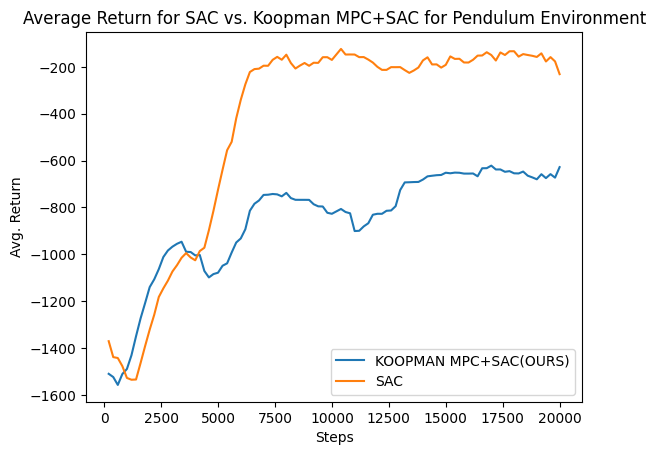

In [11]:
all_ep_returns_KOOPMAN = load_ep_returns(r"returns\ep_returns_KOOPMAN.npy")
all_ep_returns_SAC = load_ep_returns(r"returns\ep_returns_SAC.npy")
plot_evaluated_return(all_ep_returns_KOOPMAN)
plot_evaluated_return(all_ep_returns_SAC)
plt.title("Average Return for SAC vs. Koopman MPC+SAC for Pendulum Environment")
plt.xlabel("Steps")
plt.ylabel("Avg. Return")
plt.legend(["KOOPMAN MPC+SAC(OURS)", "SAC"])
